## Imports

In [1]:
import torch
from torch.utils.data import DataLoader
from data import ParenthesizationDataset
from model import Model
from train import train_one_epoch, compute_validation_loss
from evaluate import evaluate_model, predict 
from interpret import plot_linear_layer, incorrect_predictions, token_contributions, activations
import matplotlib.pyplot as plt
import seaborn as sns

## Initialize model, loaders, loss function, optimizer
`checkpoint_epochs` is the number of epochs before a checkpoint is saved. Use `data_prefix` to choose the "small" dataset.

In [2]:
epochs = 20 #20
checkpoint_epochs = 2
batch_size = 64
d_model = 16
nhead = 4
num_layers = 1
n_vocab = 4
data_prefix = "small"

training_dataset = ParenthesizationDataset(f"{data_prefix}training")
validation_dataset = ParenthesizationDataset(f"{data_prefix}validation")
test_dataset = ParenthesizationDataset(f"{data_prefix}test")

training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = Model(n_vocab, d_model, nhead, num_layers)
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train model
`start_epoch` can be set to a value greater than 0 to resume training from a checkpoint.

In [3]:
start_epoch = 0

training_loss = []
validation_loss = []
best_validation_loss = float("inf")

def save():
    torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'training_loss': training_loss,
      'validation_loss': validation_loss
    }, f"checkpoints/epoch_{epoch}.pth")

def resume(epoch):
    global training_loss, validation_loss
    checkpoint = torch.load(f"checkpoints/epoch_{epoch}.pth")
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    training_loss = checkpoint["training_loss"]
    validation_loss = checkpoint["validation_loss"]

if start_epoch > 0:
    resume(start_epoch)
    start_epoch += 1

for epoch in range(start_epoch, epochs):
    model.train(True)
    training_loss.append(train_one_epoch(training_loader, model, loss_fn, optimizer))
    validation_loss.append(compute_validation_loss(validation_loader, model, loss_fn))
    print(f"Epoch {epoch}, Training Loss {training_loss[-1]}, Validation Loss {validation_loss[-1]}")

    if (epoch+1) % checkpoint_epochs == 0:
        save()

Epoch 0, Training Loss 0.7021266849608372, Validation Loss 0.6941603679282993
Epoch 1, Training Loss 0.6926644746660824, Validation Loss 0.6947153222327139
Epoch 2, Training Loss 0.6750224116947037, Validation Loss 0.5759569710376216
Epoch 3, Training Loss 0.44014449128274574, Validation Loss 0.49281122988345577
Epoch 4, Training Loss 0.3726548312715982, Validation Loss 0.3820550558613796
Epoch 5, Training Loss 0.2970610040030825, Validation Loss 0.2861031176997166
Epoch 6, Training Loss 0.25268334886756383, Validation Loss 0.22863835914462222
Epoch 7, Training Loss 0.20874336066219912, Validation Loss 0.19471063976194344
Epoch 8, Training Loss 0.19400162894190337, Validation Loss 0.2328147899870779
Epoch 9, Training Loss 0.19641175331027494, Validation Loss 0.18158947515721416
Epoch 10, Training Loss 0.2381415179932328, Validation Loss 0.22746125506419762
Epoch 11, Training Loss 0.15385125449570083, Validation Loss 0.1837477085052752
Epoch 12, Training Loss 0.15185297739012388, Valida

# Plot the loss curve for training and validation

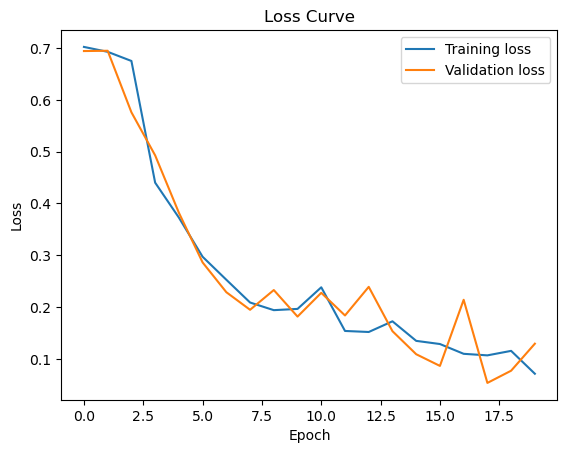

In [4]:
# Plot loss function
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

# Evaluate the model and plot the confusion matrix

/Users/hansonmo/opt/anaconda3/envs/py12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_68u_j54pu8/croot/pytorch-select_1717607460029/work/aten/src/ATen/NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training data set accuracy:
Accuracy for class 0 = 98.84287454323996%
Accuracy for class 1 = 91.54501216545012%
Overall accuracy = 95.19172245891662%


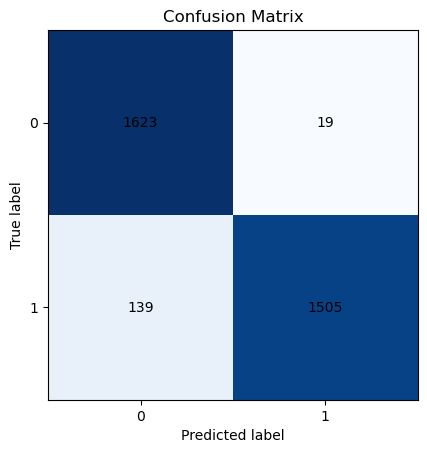

Validation data set accuracy:
Accuracy for class 0 = 99.01960784313725%
Accuracy for class 1 = 91.17647058823529%
Overall accuracy = 95.09803921568627%


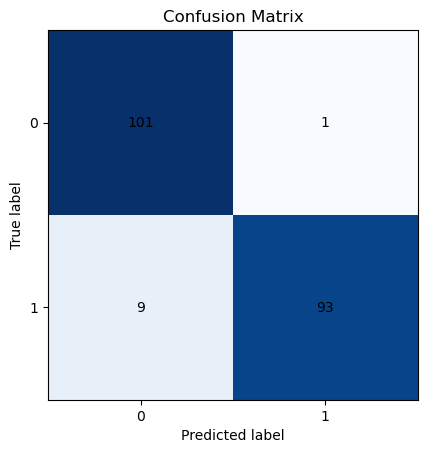

Test data set accuracy:
Accuracy for class 0 = 98.37662337662337%
Accuracy for class 1 = 88.31168831168831%
Overall accuracy = 93.34415584415585%


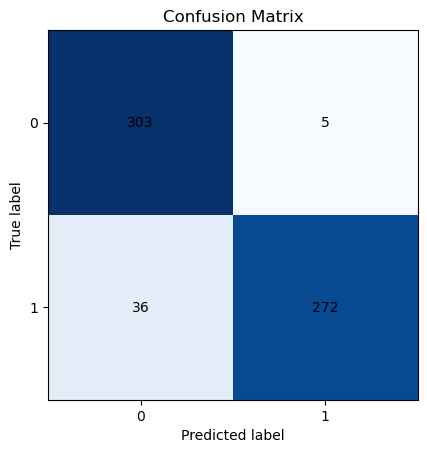

In [5]:
training_confusion_matrix = evaluate_model(model, training_loader)
validation_confusion_matrix = evaluate_model(model, validation_loader)
test_confusion_matrix = evaluate_model(model, test_loader)

print("Training data set accuracy:")
training_confusion_matrix.print_accuracy()
training_confusion_matrix.plot()

print("Validation data set accuracy:")
validation_confusion_matrix.print_accuracy()
validation_confusion_matrix.plot()

print("Test data set accuracy:")
test_confusion_matrix.print_accuracy()
test_confusion_matrix.plot()

# Interpretation
In this section you will try various techniques to interpret the model. Insert additional notebook cells as need to do the following:

1. Construct some test cases of varying lengths and display the model's predictions.
2. Compute the list of incorrect predictions and display some examples of them.
3. For each incorrect prediction, plot the token contributions as a heatmap.
4. For each position from 0 to 21, loop over all inputs in the test set and plot a histogram of the token contributions for that position.
5. Plot the heatmap for the projection layer and the second linear layer in the feedforward.
6. Loop over all inputs in the test set and count the activations in the feedforward layer. Plot the activations as a histogram to see which features in the feedforward layer are activated the most.

In [6]:
# Construct test cases of varying lengths with valid token indices within the range [0, 1]
test_cases = [
    torch.randint(0, 2, (1, 4)),  # Example with length 4
    torch.randint(0, 2, (1, 10)),  # Example with length 10
    torch.randint(0, 2, (1, 21))  # Example with length 21
]

# Display model predictions for each test case
for i, test_case in enumerate(test_cases):
    print(f"Test Case {i + 1}: {test_case.tolist()}")
    output = model(test_case)
    print(f"Model Prediction: {output.argmax(dim=1).tolist()}\n")


Test Case 1: [[0, 1, 0, 0]]
Model Prediction: [[0, 1]]

Test Case 2: [[1, 0, 1, 1, 1, 1, 1, 1, 1, 1]]
Model Prediction: [[9, 0]]

Test Case 3: [[1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]]
Model Prediction: [[18, 8]]



In [7]:
def check_data_distribution(dataloader):
    label_counts = [0, 0]
    for _, labels in dataloader:
        for label in labels:
            label_counts[label.item()] += 1

    print("Label distribution in the test set:")
    print(f"Class 0: {label_counts[0]}")
    print(f"Class 1: {label_counts[1]}")

check_data_distribution(test_loader)


Label distribution in the test set:
Class 0: 308
Class 1: 308


In [8]:
def check_data_distribution(dataloader):
    label_counts = [0, 0]
    for _, labels in dataloader:
        for label in labels:
            label_counts[label.item()] += 1

    print("Label distribution in the training set:")
    print(f"Class 0: {label_counts[0]}")
    print(f"Class 1: {label_counts[1]}")

check_data_distribution(training_loader)


Label distribution in the training set:
Class 0: 1642
Class 1: 1644


In [9]:
# Compute incorrect predictions
incorrect_preds = incorrect_predictions(model, test_loader)
print('Incorrect Predictions:', incorrect_preds)

# Print the number of incorrect predictions
num_incorrect = sum(len(preds) for preds in incorrect_preds)
print(f'Number of Incorrect Predictions: {num_incorrect}')

Incorrect Predictions: [[[2, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]], [[2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [10]:
# Compute incorrect predictions
incorrect_preds = incorrect_predictions(model, test_loader)

# Display some examples of incorrect predictions
print("Incorrect Predictions:")
for label, preds in enumerate(incorrect_preds):
    print(f"Label {label}: {len(preds)} incorrect predictions")
    if preds:
        print(f"Examples: {preds[:3]}\n")

Incorrect Predictions:
Label 0: 5 incorrect predictions
Examples: [[2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]

Label 1: 36 incorrect predictions
Examples: [[2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]



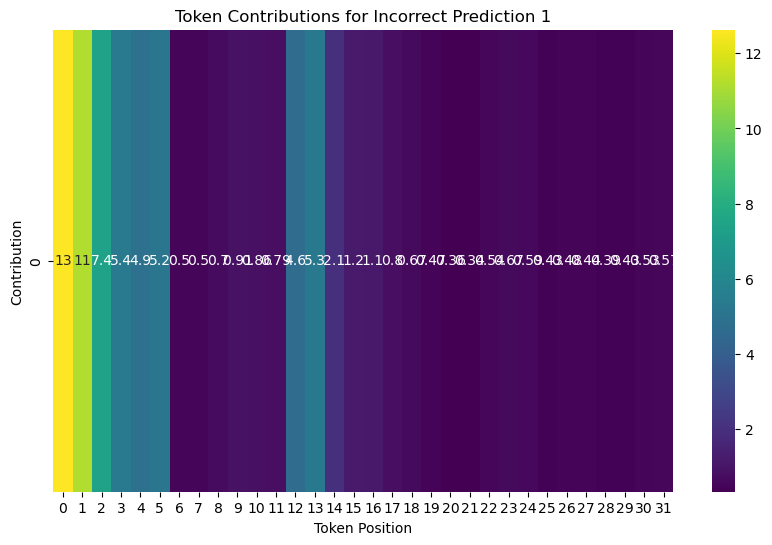

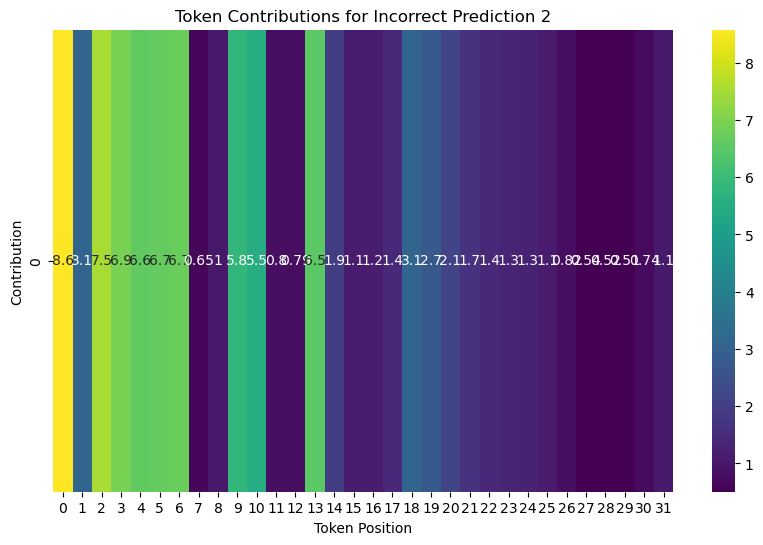

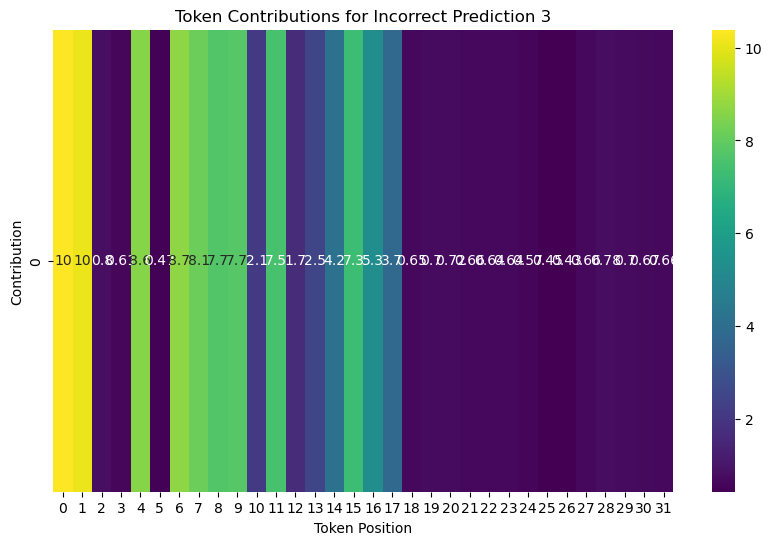

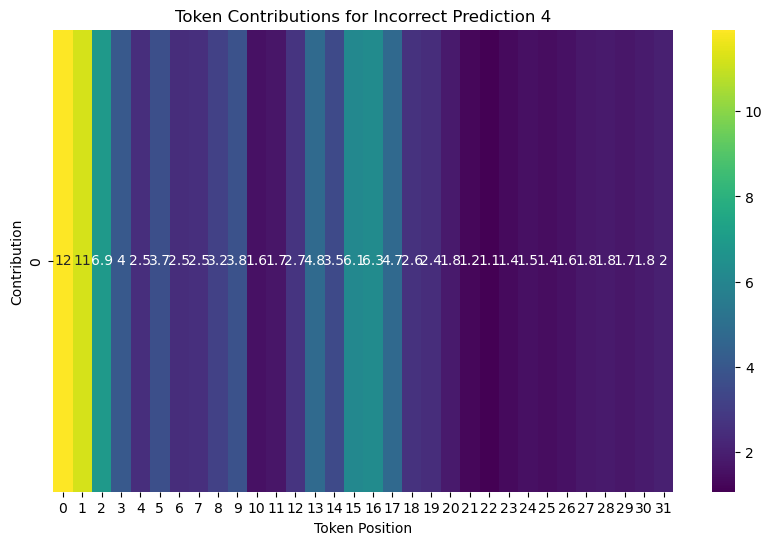

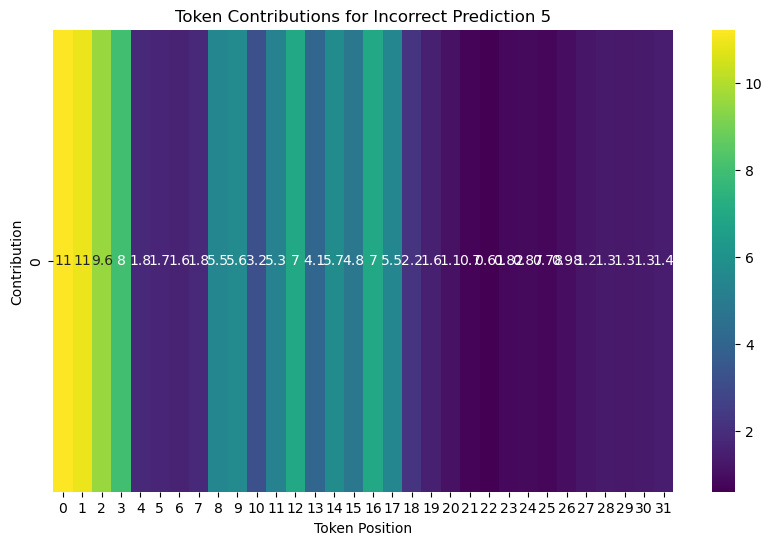

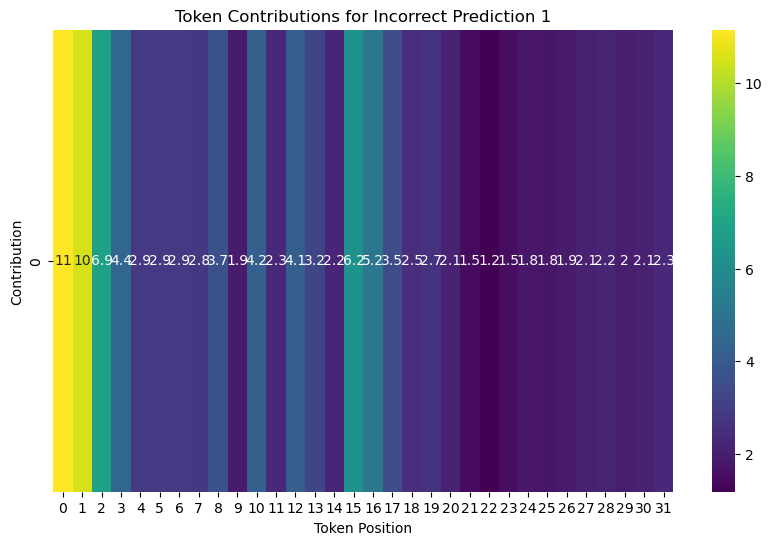

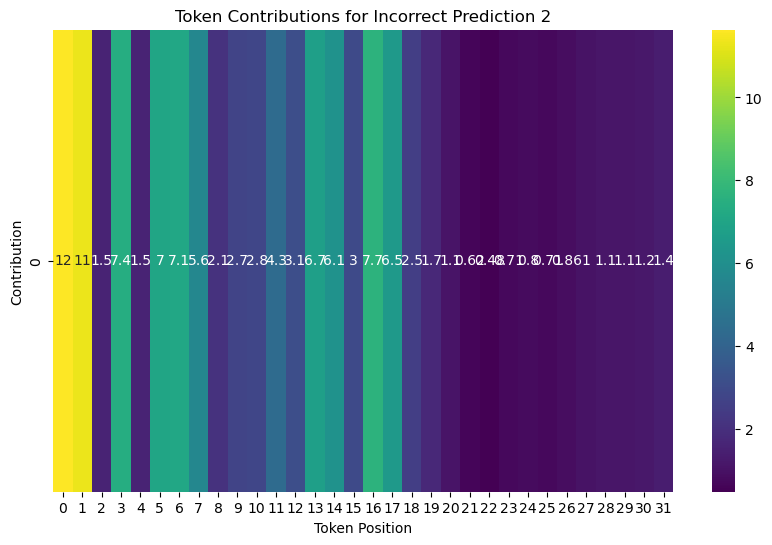

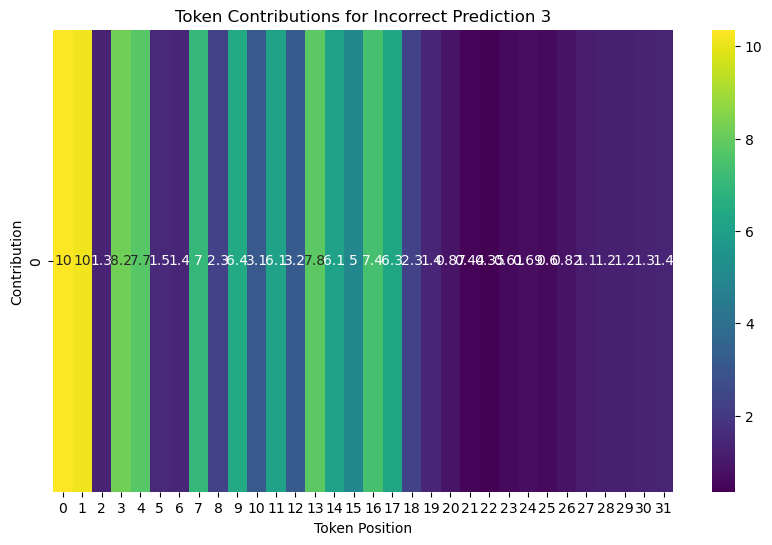

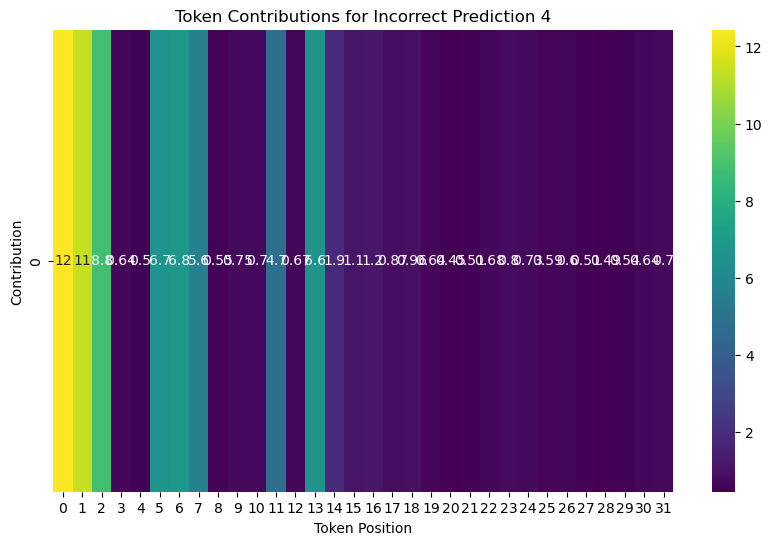

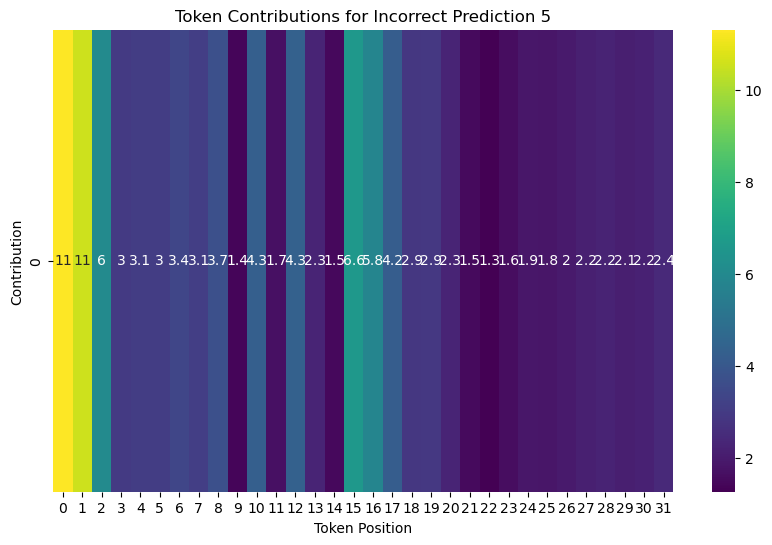

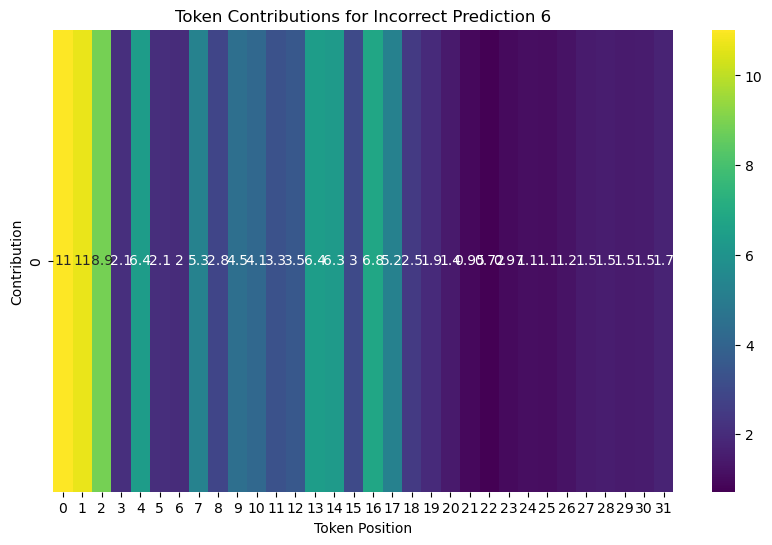

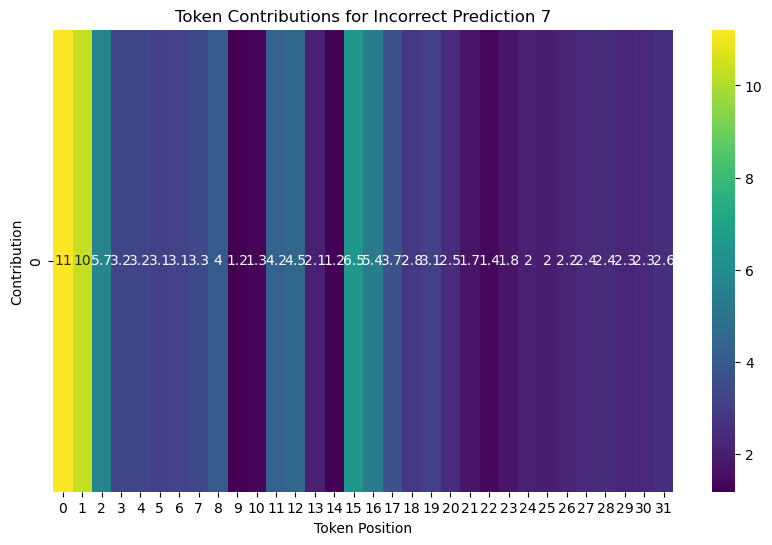

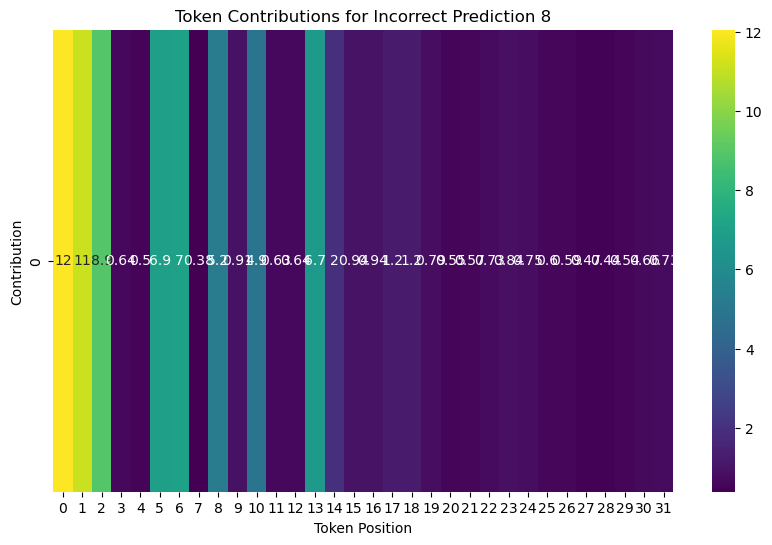

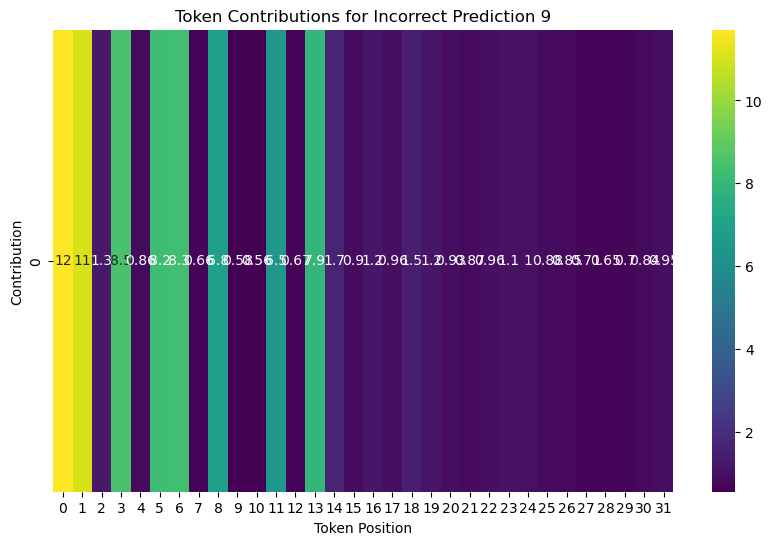

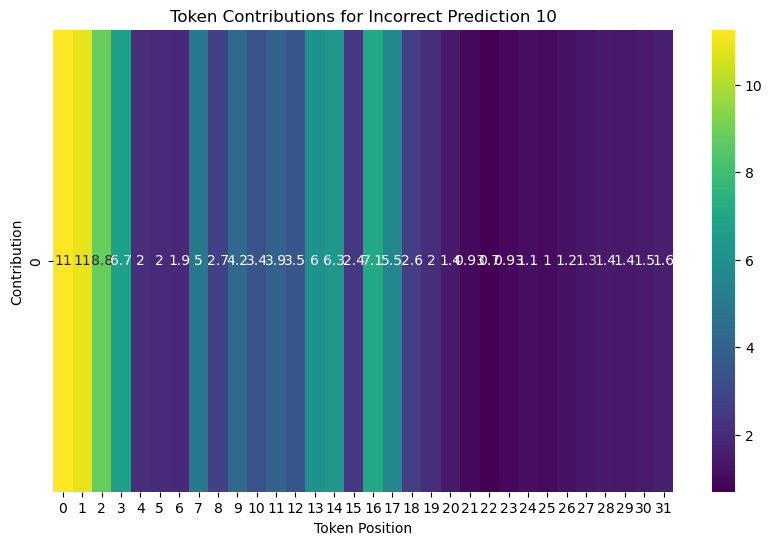

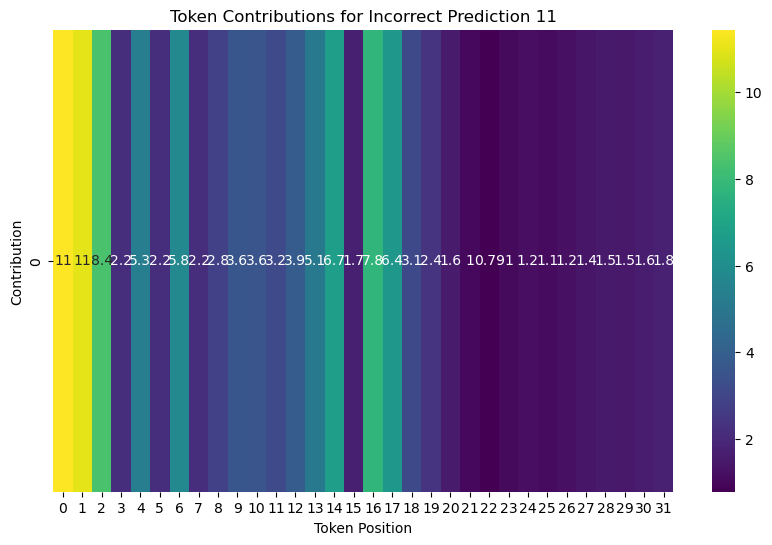

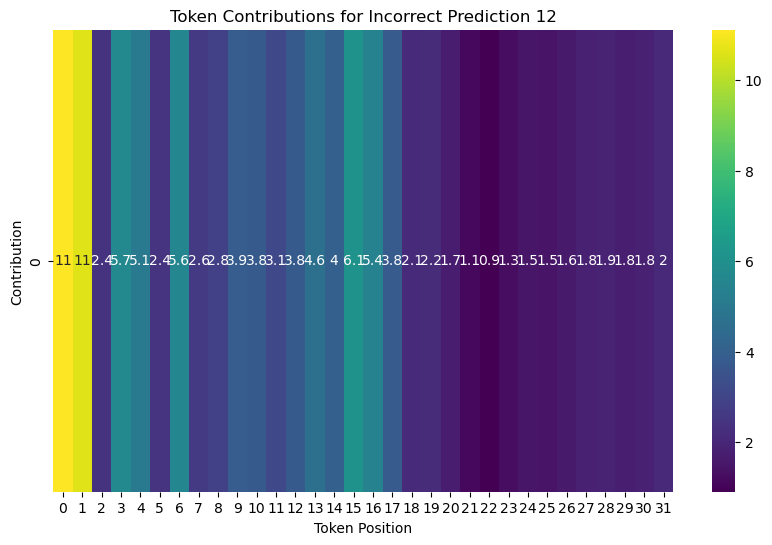

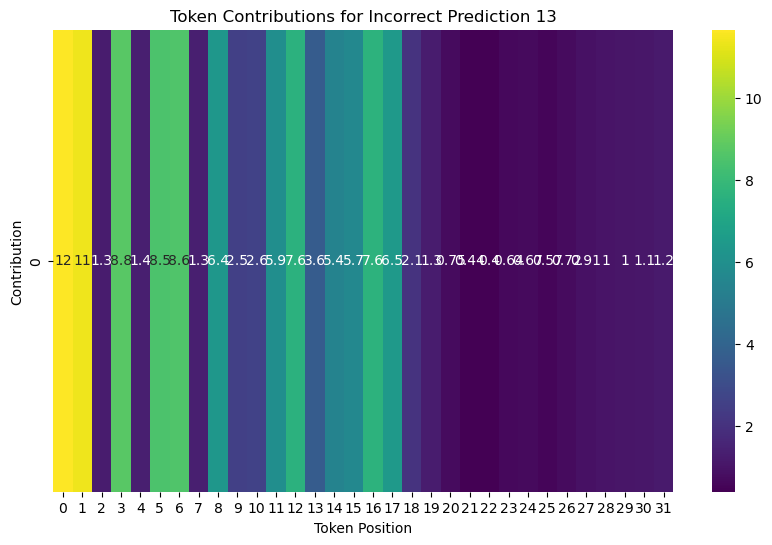

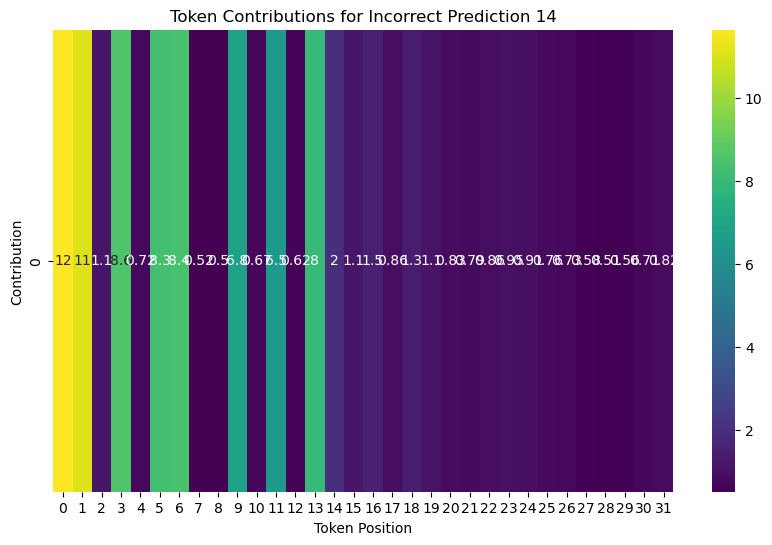

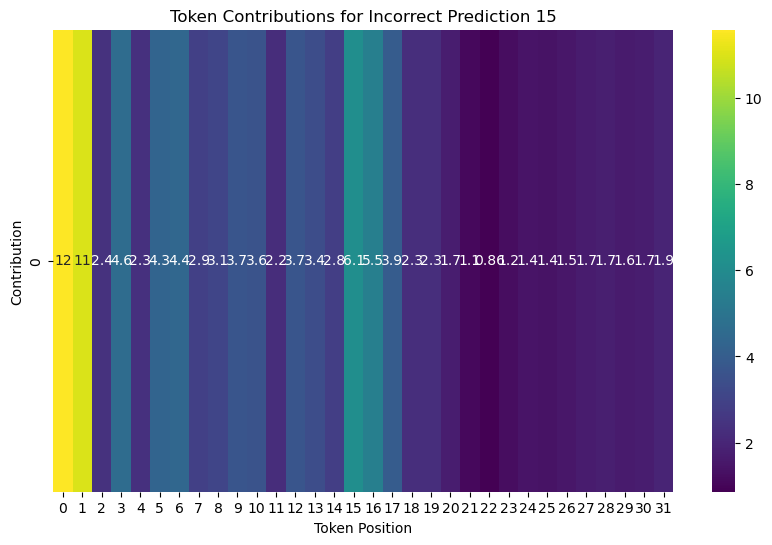

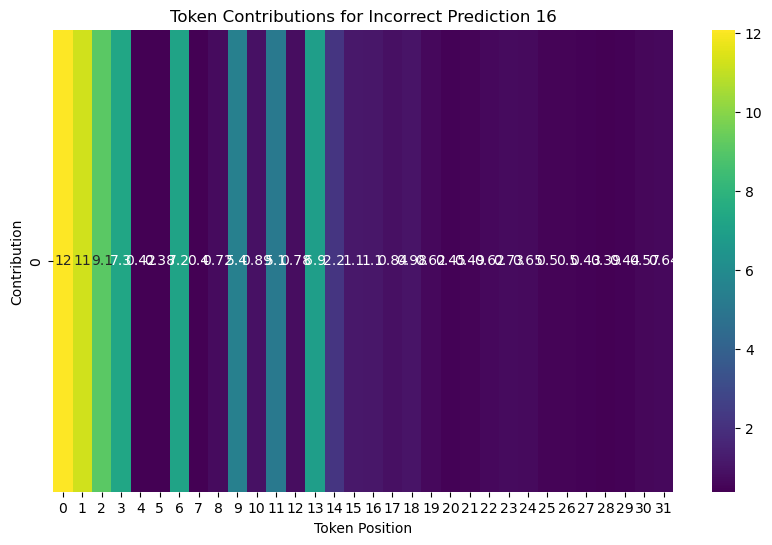

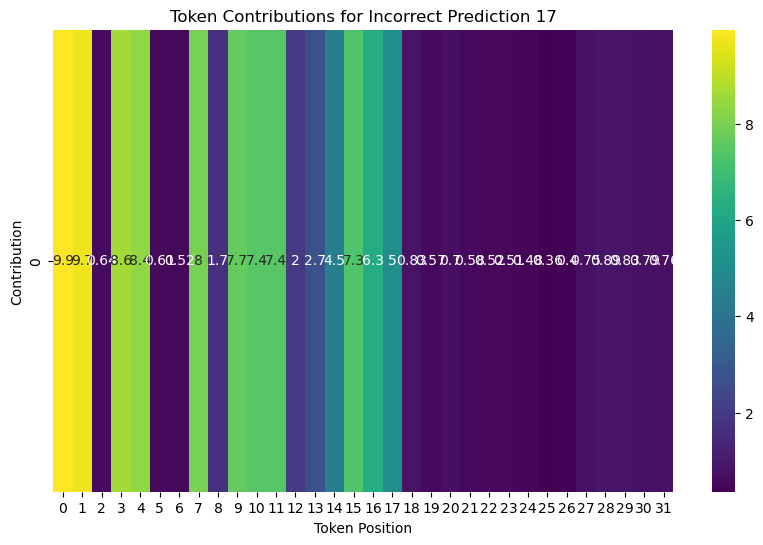

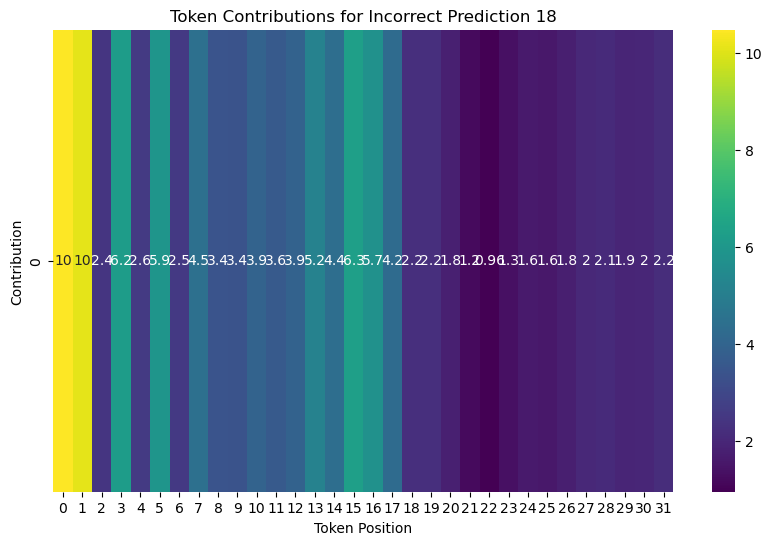

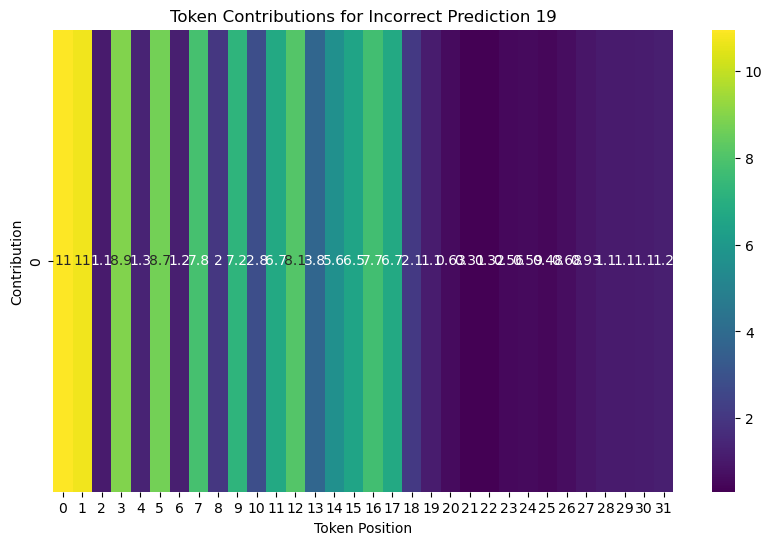

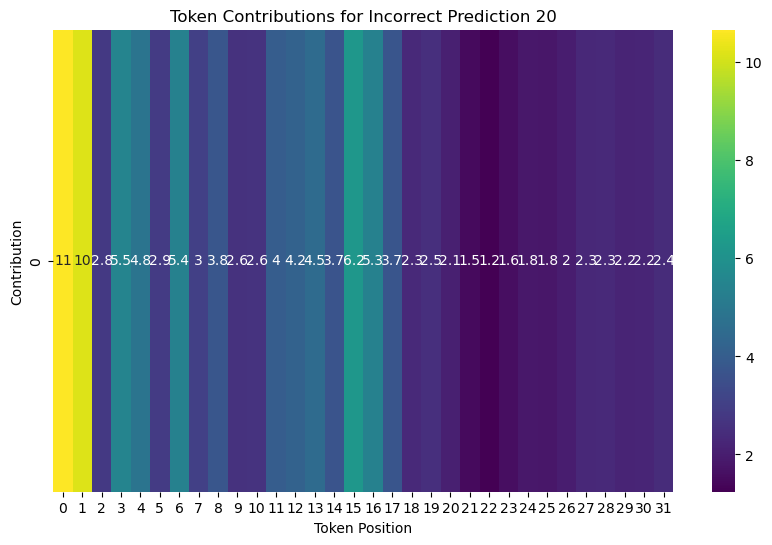

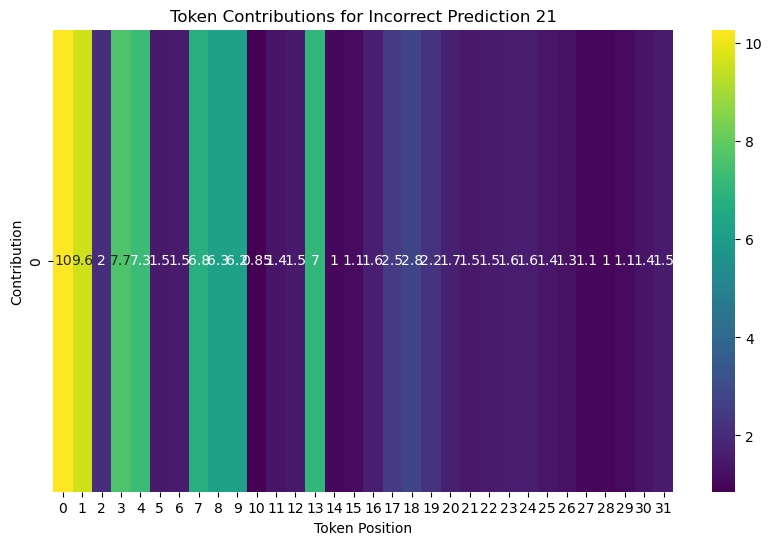

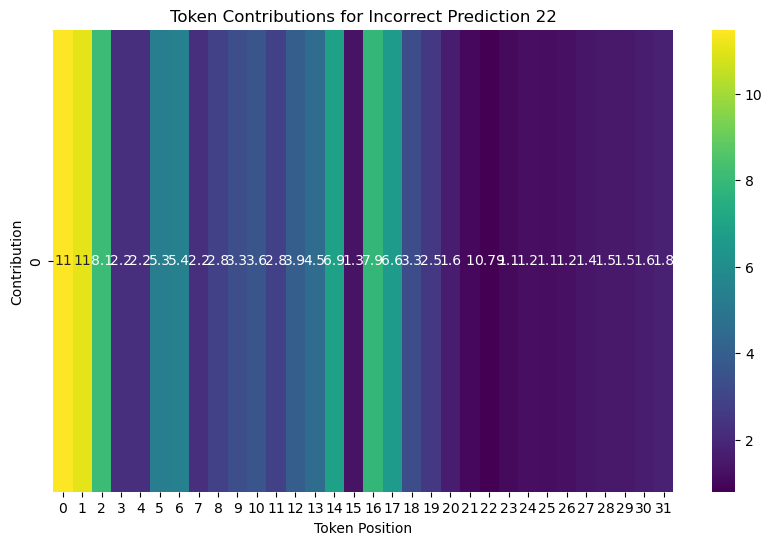

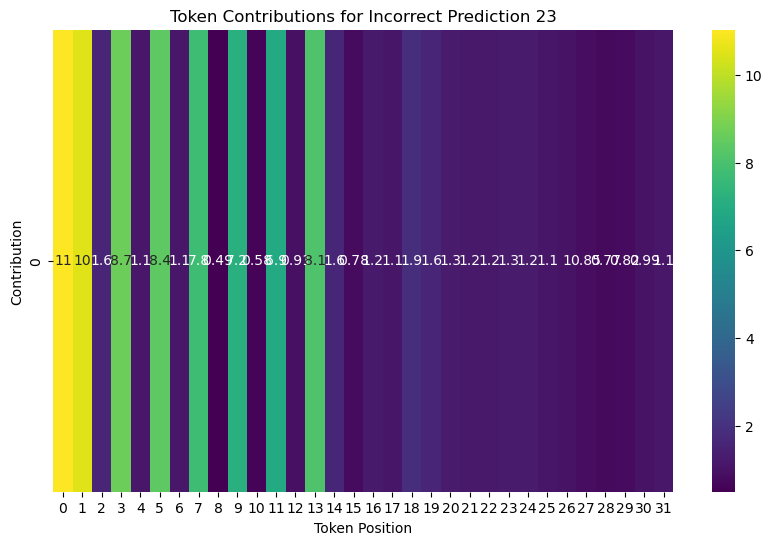

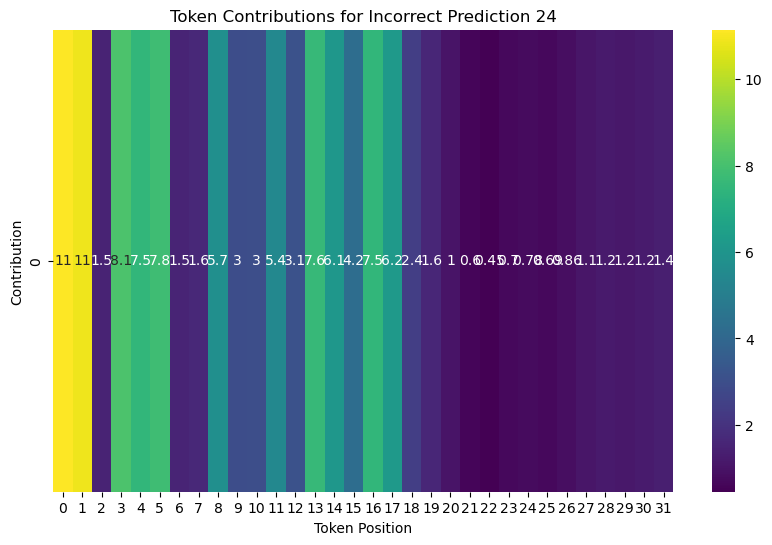

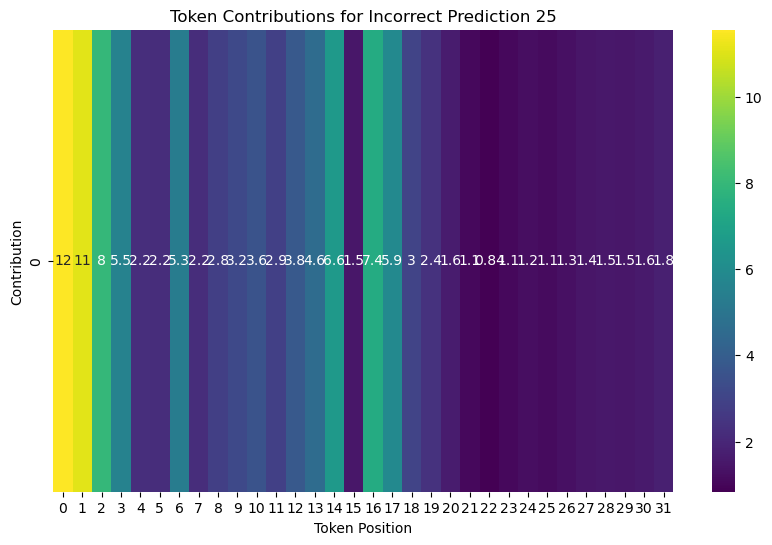

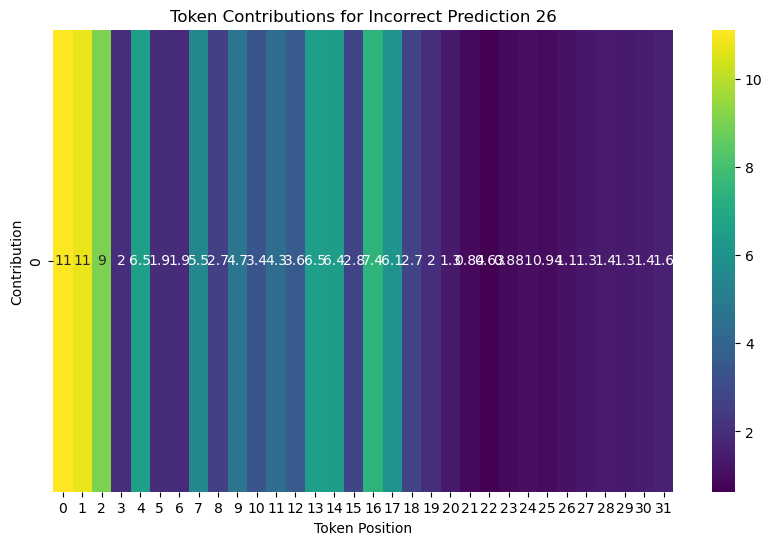

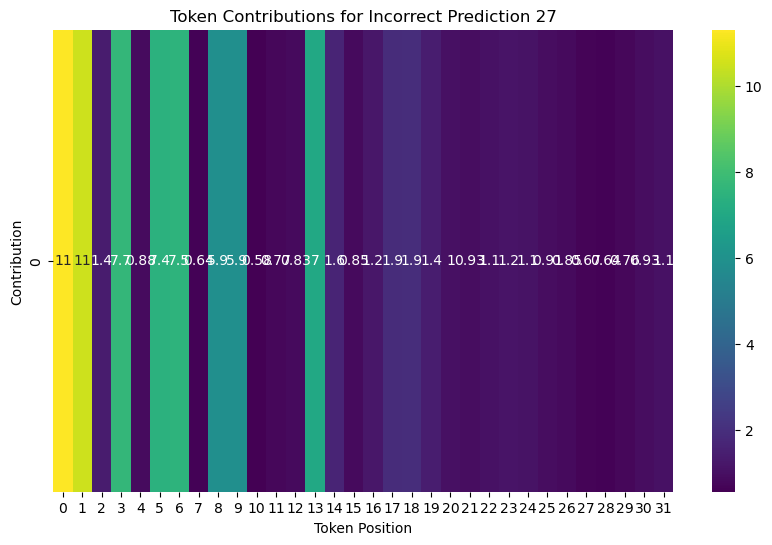

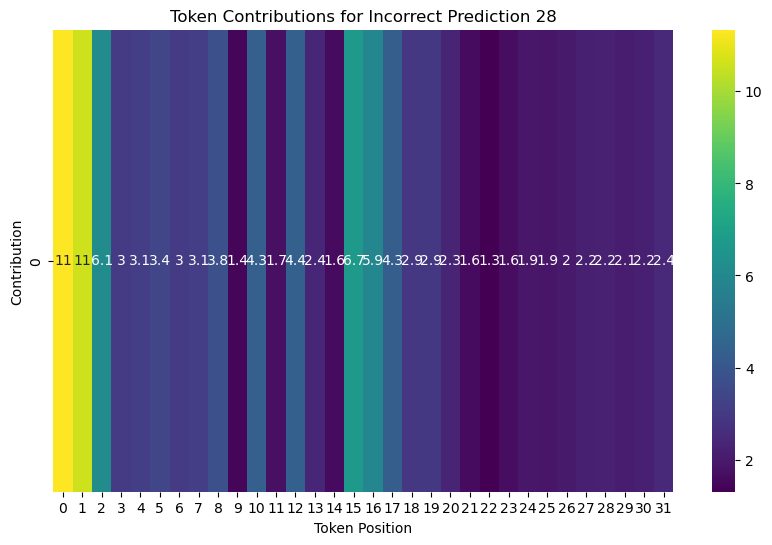

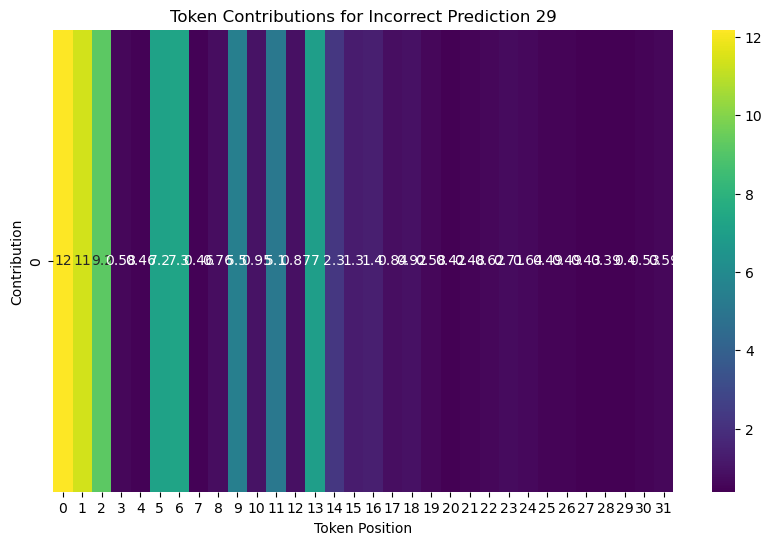

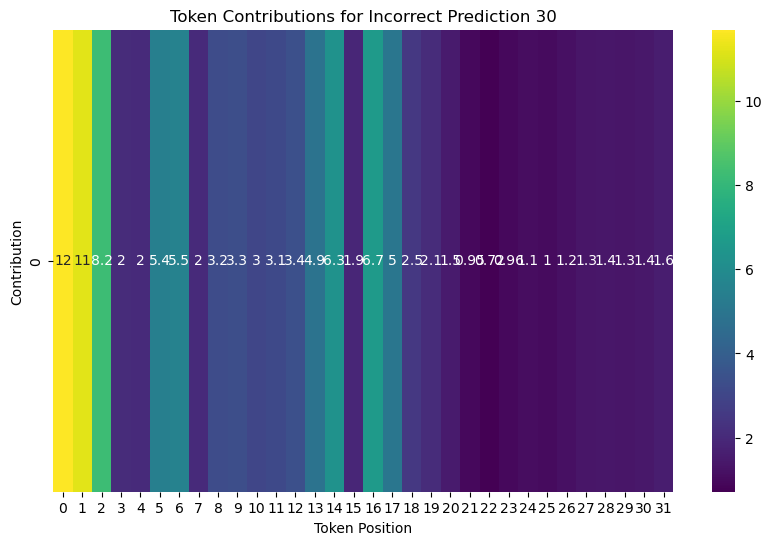

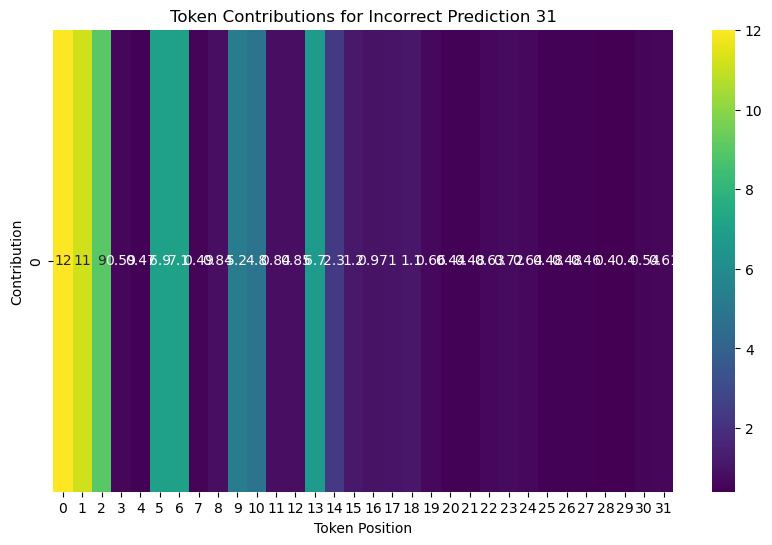

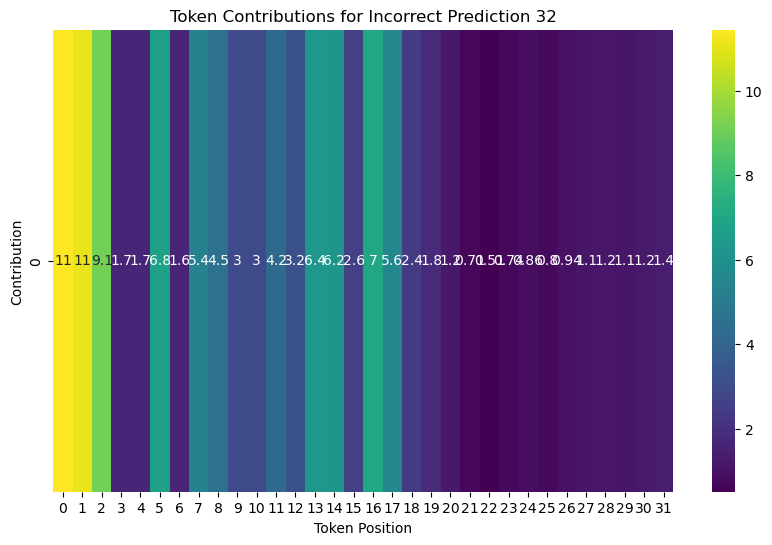

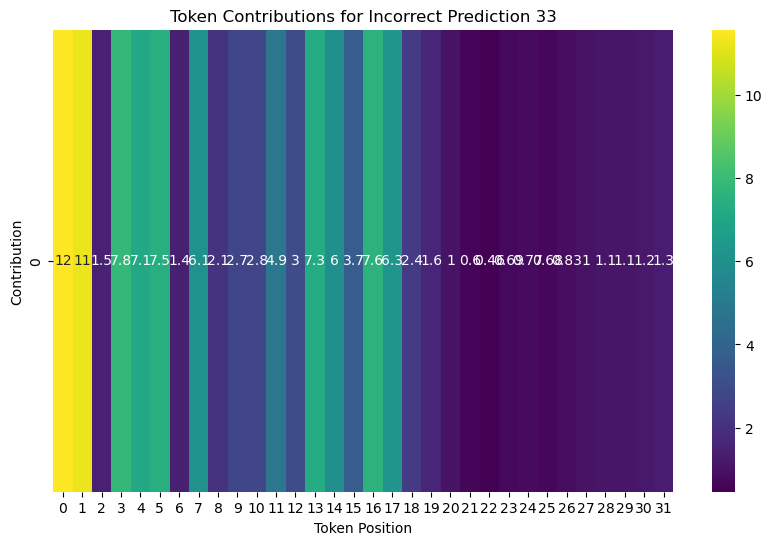

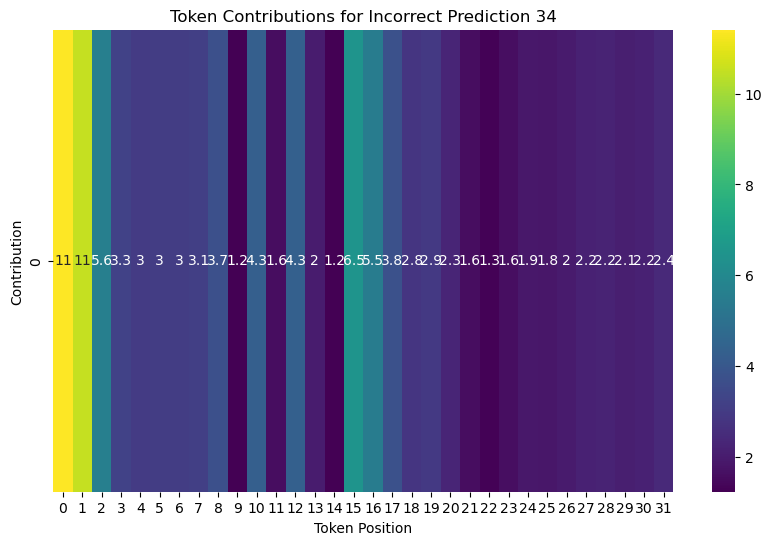

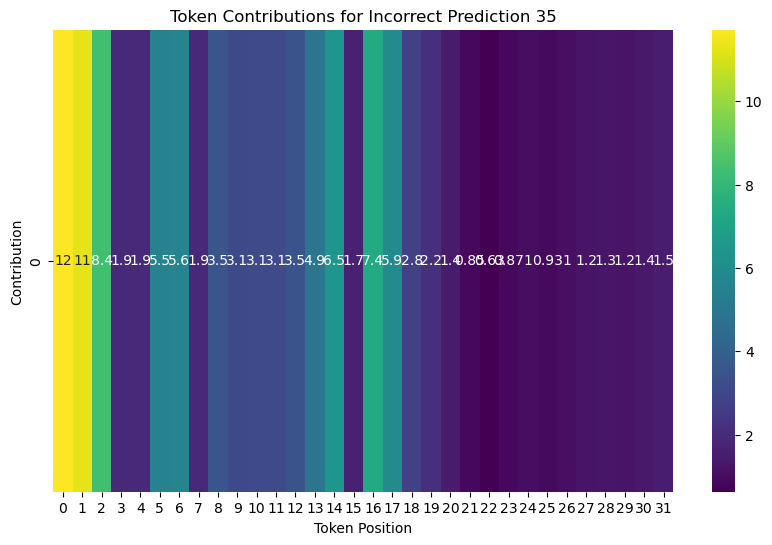

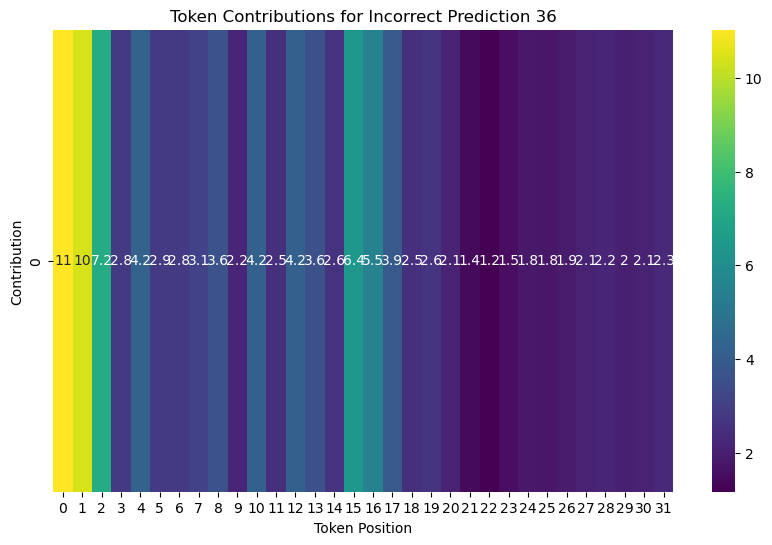

"\nif len(incorrect_preds[0]) > 0:\n    example_input = torch.tensor(incorrect_preds[0][0]).unsqueeze(0)\n    contributions = token_contributions(model, example_input)\n    plt.figure(figsize=(10, 6))\n    sns.heatmap([contributions], annot=True, cmap='viridis')\n    plt.title('Token Contributions')\n    plt.xlabel('Token Position')\n    plt.ylabel('Contribution')\n    plt.show()\n"

In [11]:
# Plot token contributions for the incorrect prediction
for i, incorrect_prediction in enumerate(incorrect_preds[0][:num_incorrect]):
    example_input = torch.tensor(incorrect_prediction).unsqueeze(0)
    contributions = token_contributions(model, example_input)
    
    # Plotting the contributions
    plt.figure(figsize=(10, 6))
    sns.heatmap([contributions], annot=True, cmap='viridis')
    plt.title(f'Token Contributions for Incorrect Prediction {i+1}')
    plt.xlabel('Token Position')
    plt.ylabel('Contribution')
    plt.show()

for i, incorrect_prediction in enumerate(incorrect_preds[1][:num_incorrect]):
    example_input = torch.tensor(incorrect_prediction).unsqueeze(0)
    contributions = token_contributions(model, example_input)
    
    # Plotting the contributions
    plt.figure(figsize=(10, 6))
    sns.heatmap([contributions], annot=True, cmap='viridis')
    plt.title(f'Token Contributions for Incorrect Prediction {i+1}')
    plt.xlabel('Token Position')
    plt.ylabel('Contribution')
    plt.show()

"""
if len(incorrect_preds[0]) > 0:
    example_input = torch.tensor(incorrect_preds[0][0]).unsqueeze(0)
    contributions = token_contributions(model, example_input)
    plt.figure(figsize=(10, 6))
    sns.heatmap([contributions], annot=True, cmap='viridis')
    plt.title('Token Contributions')
    plt.xlabel('Token Position')
    plt.ylabel('Contribution')
    plt.show()
"""


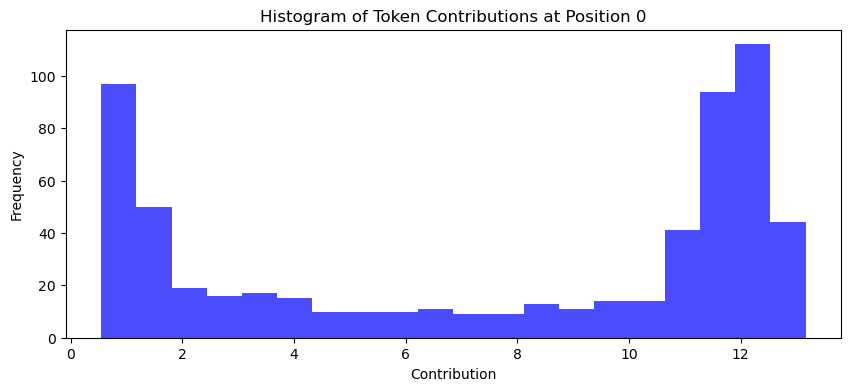

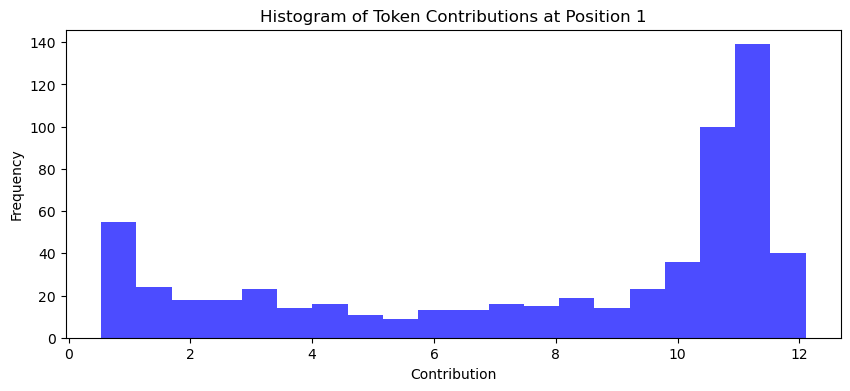

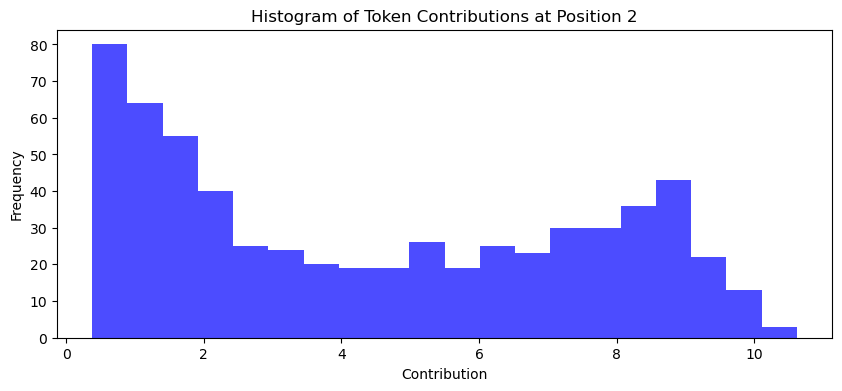

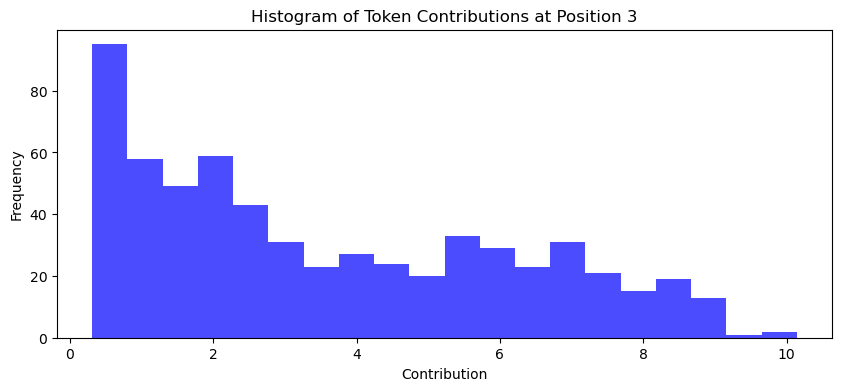

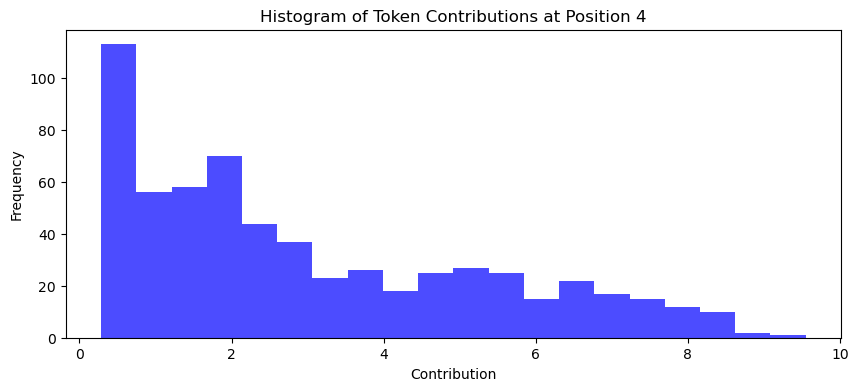

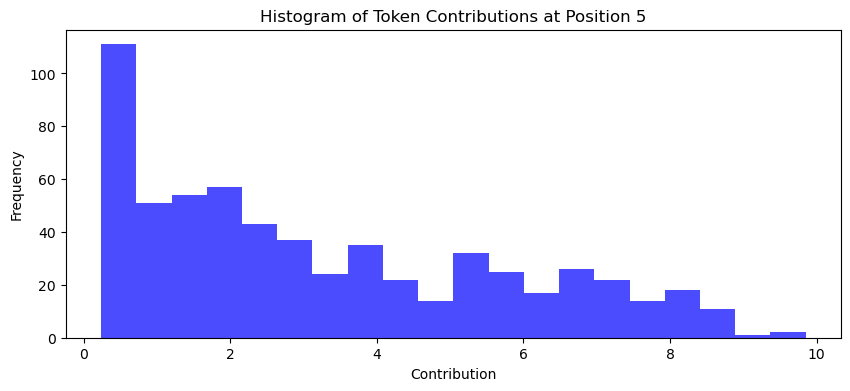

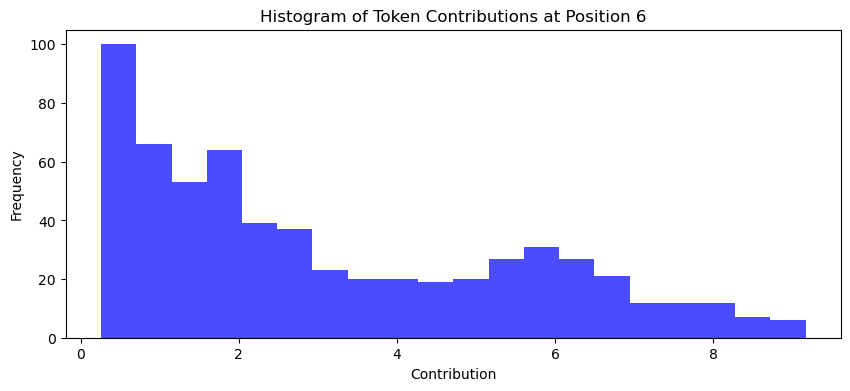

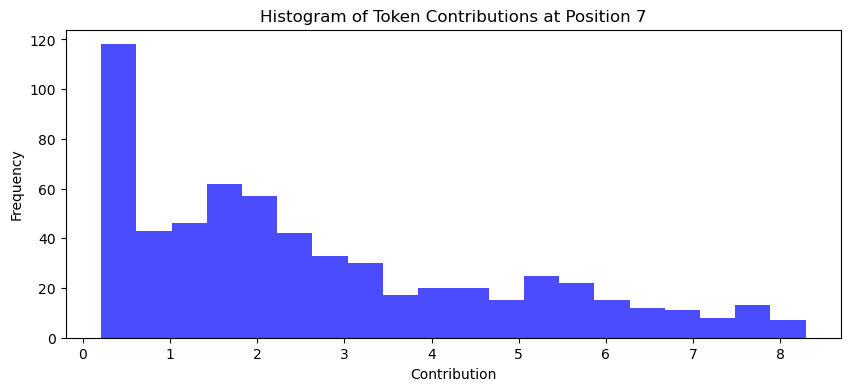

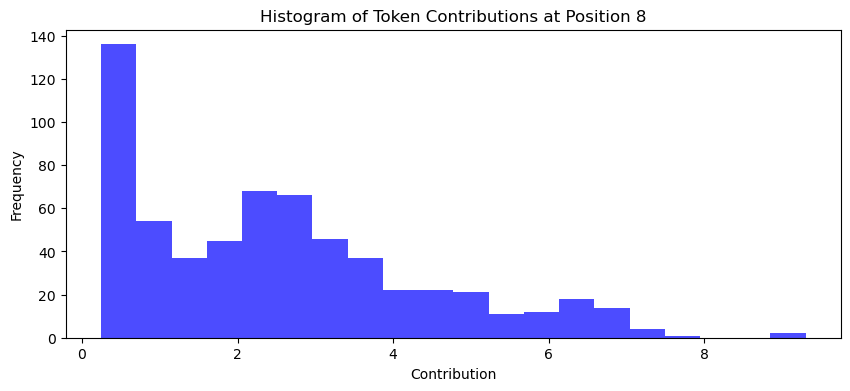

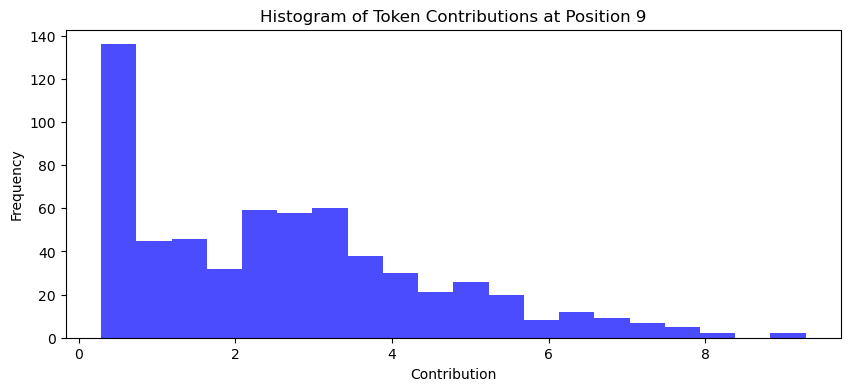

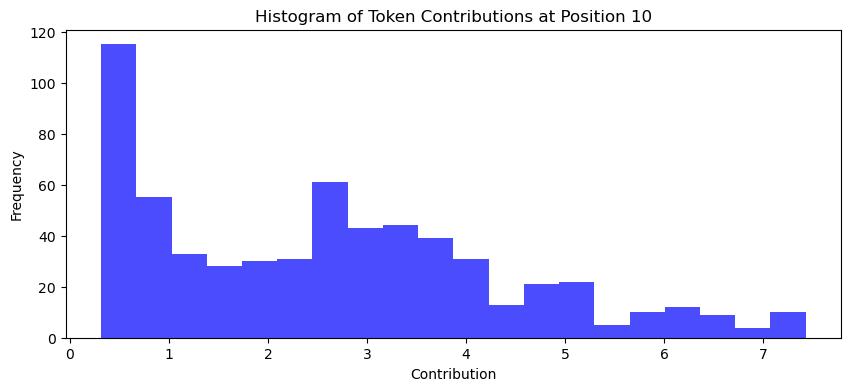

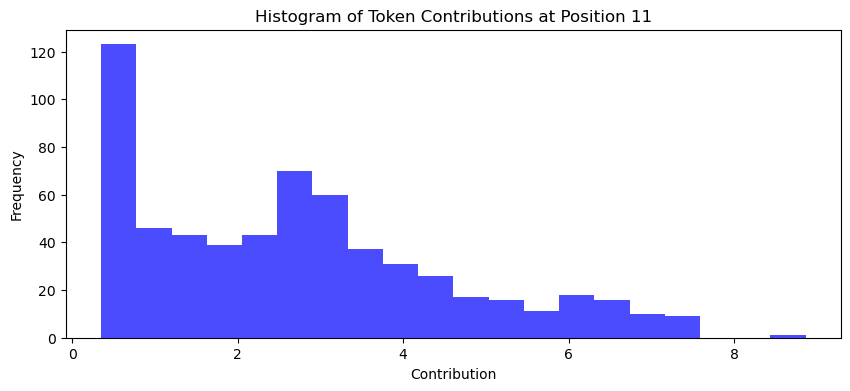

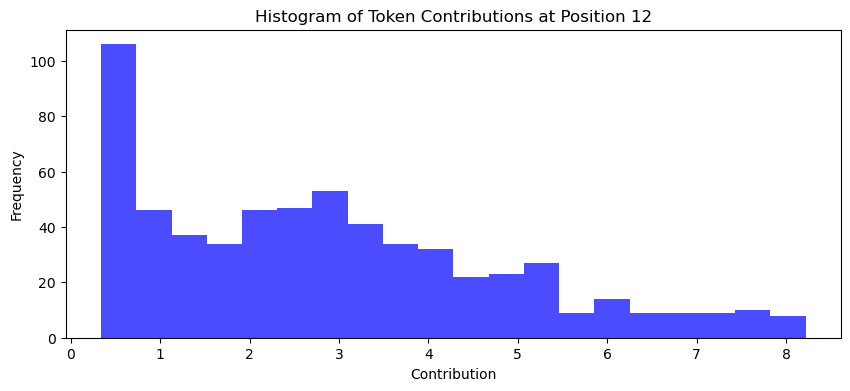

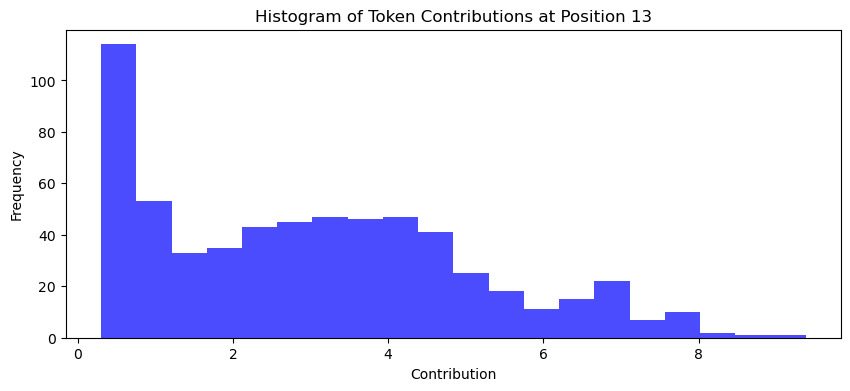

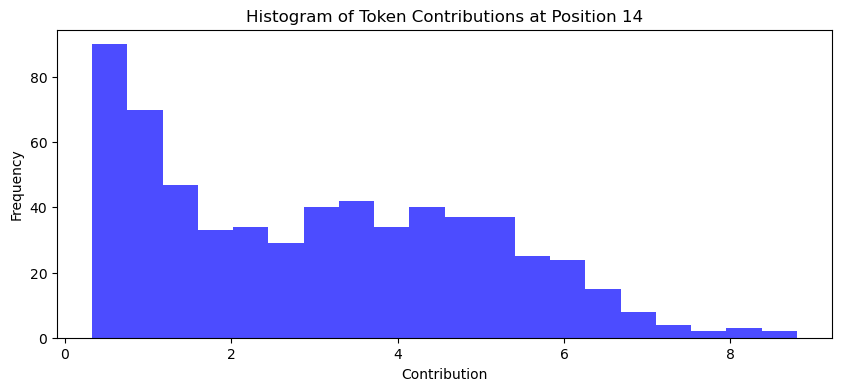

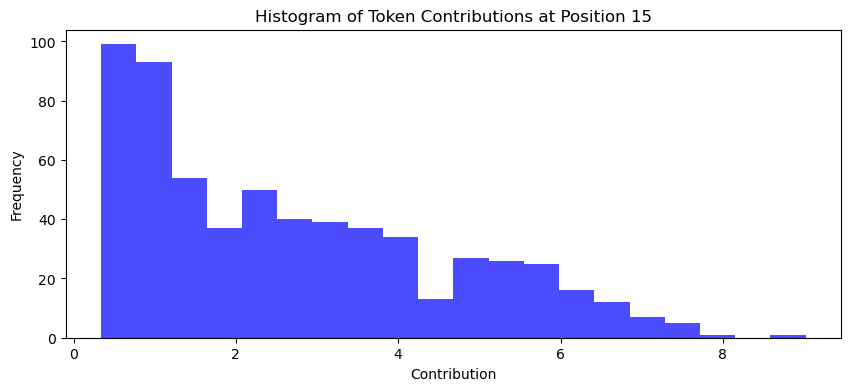

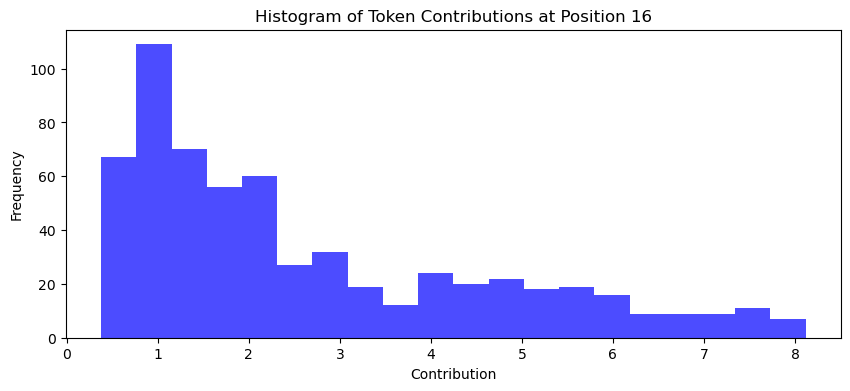

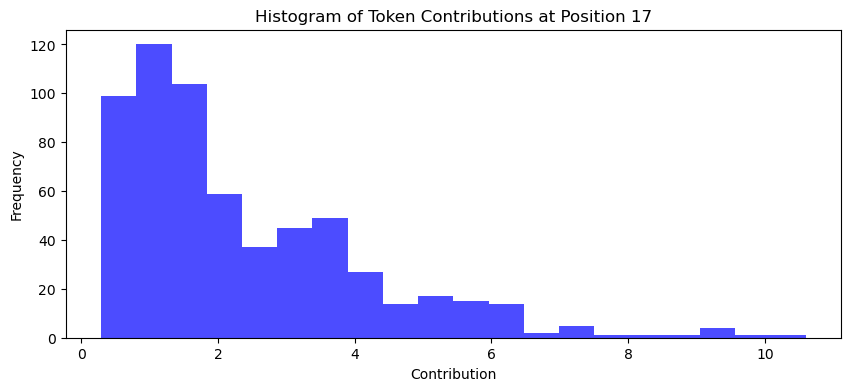

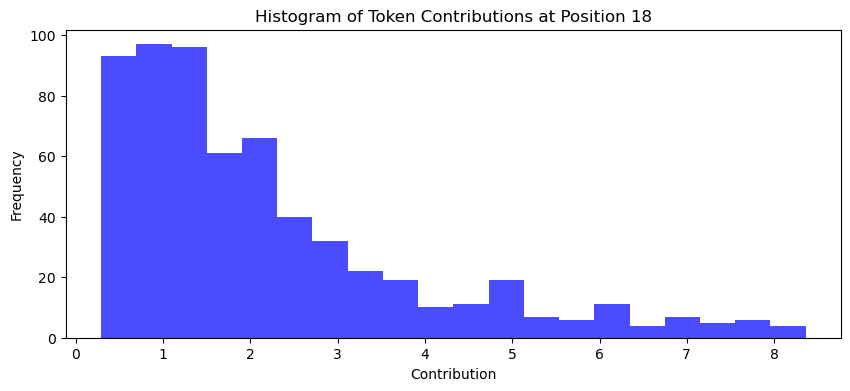

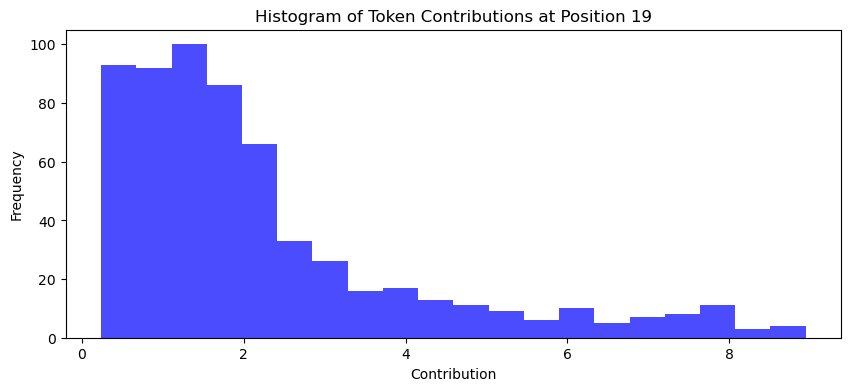

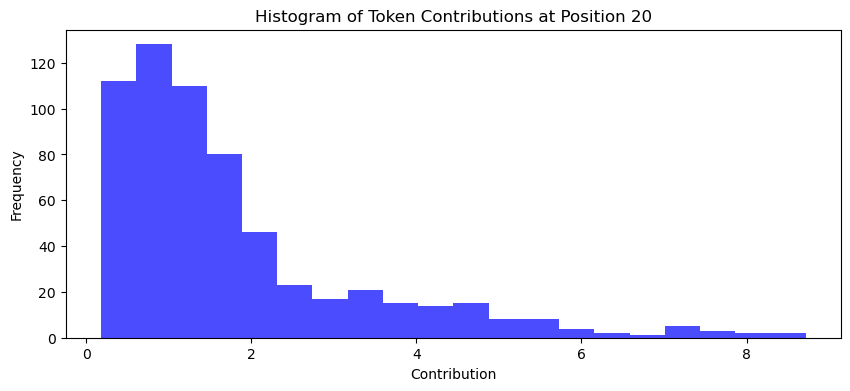

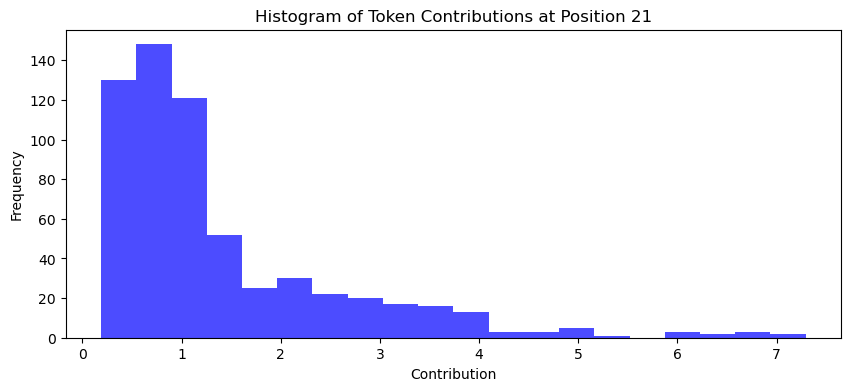

In [12]:
# Loop over all inputs in the test set and plot histogram of token contributions for each position
for position in range(22):
    contributions_at_position = []
    for inputs, _ in test_loader:
        for single_input in inputs:
            contributions = token_contributions(model, single_input.unsqueeze(0))
            if position < len(contributions):
                contributions_at_position.append(contributions[position])
    plt.figure(figsize=(10, 4))
    plt.hist(contributions_at_position, bins=20, alpha=0.7, color='blue')
    plt.title(f"Histogram of Token Contributions at Position {position}")
    plt.xlabel("Contribution")
    plt.ylabel("Frequency")
    plt.show()

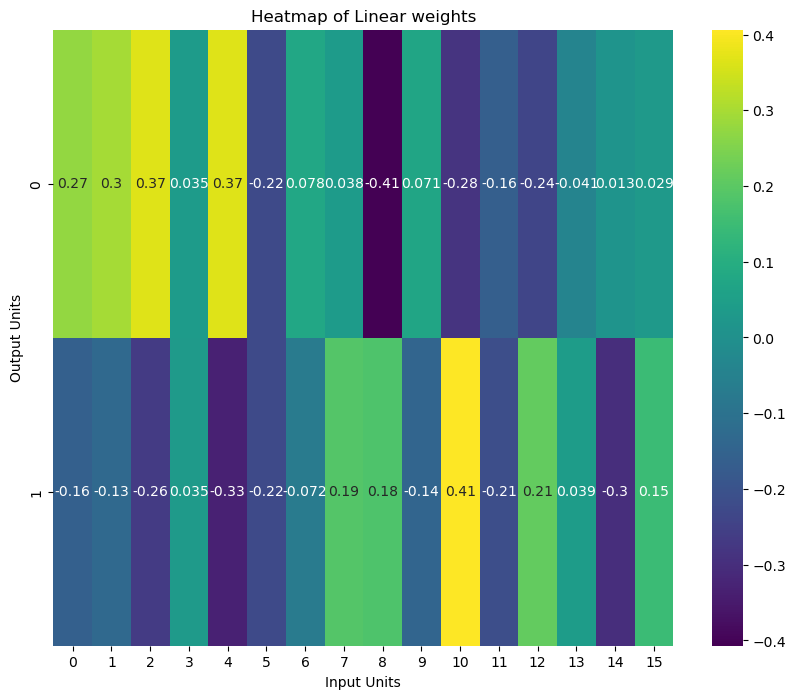

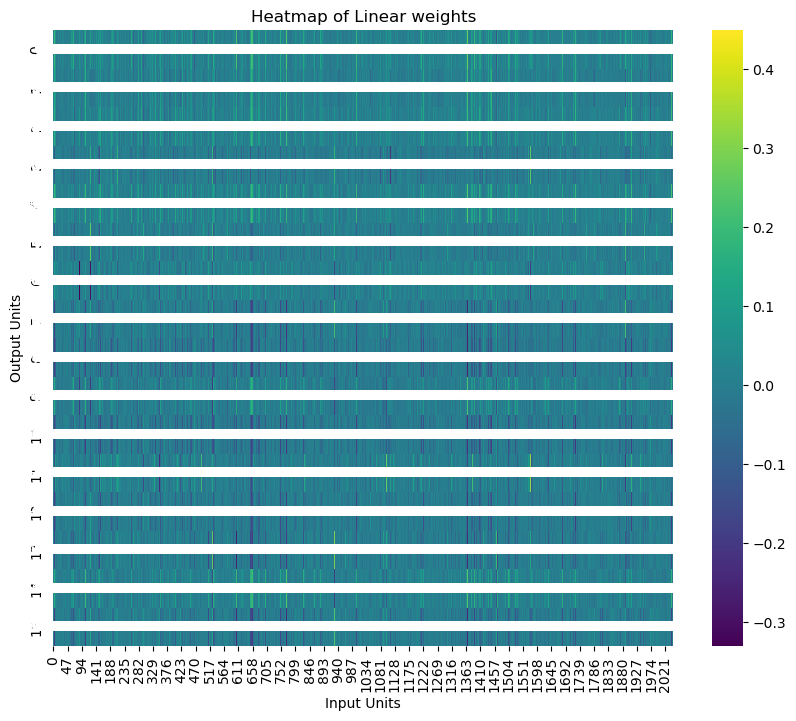

In [13]:
# Plot heatmap for the projection layer
plot_linear_layer(model.proj)

# Plot heatmap for the feedforward layer
plot_linear_layer(model.encoder.layers[0].linear2)


Hook triggered
Output shape: torch.Size([64, 32, 16])
Hook triggered
Output shape: torch.Size([64, 32, 16])
Hook triggered
Output shape: torch.Size([64, 32, 16])
Hook triggered
Output shape: torch.Size([64, 32, 16])
Hook triggered
Output shape: torch.Size([64, 32, 16])
Hook triggered
Output shape: torch.Size([64, 32, 16])
Hook triggered
Output shape: torch.Size([64, 32, 16])
Hook triggered
Output shape: torch.Size([64, 32, 16])
Hook triggered
Output shape: torch.Size([64, 32, 16])
Hook triggered
Output shape: torch.Size([40, 32, 16])
Activation counts shape: (616, 32, 16)


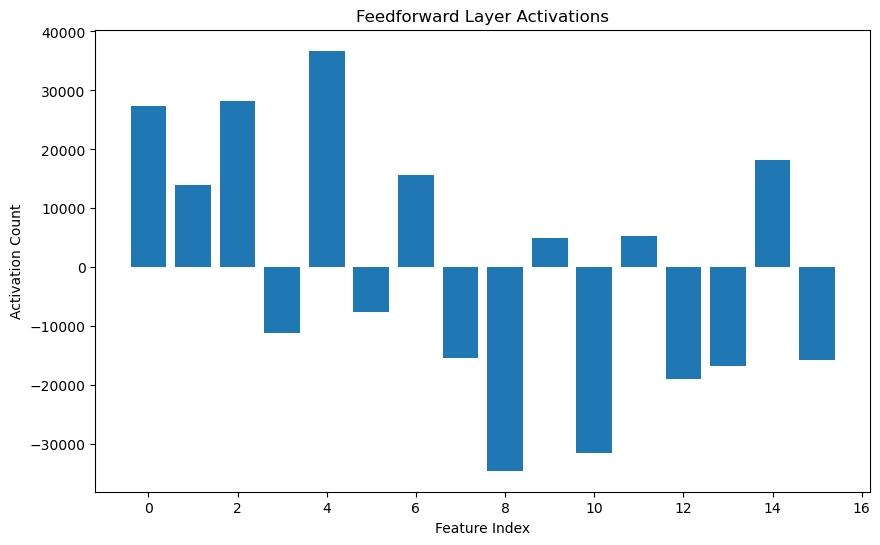

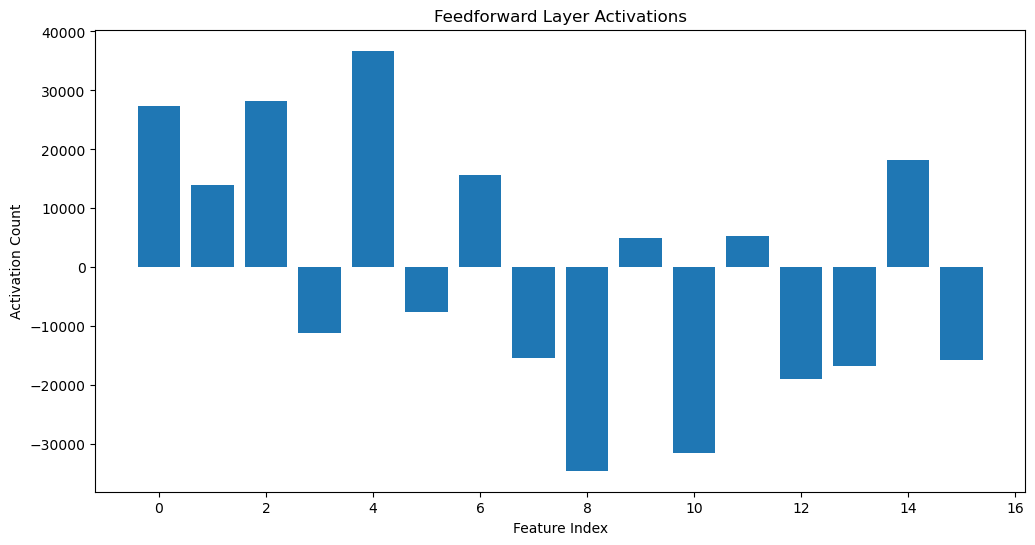

In [14]:
# Compute and plot activations
activation_counts = activations(model, test_loader)
plt.figure(figsize=(12, 6))
plt.bar(range(len(activation_counts)), activation_counts)
plt.xlabel('Feature Index')
plt.ylabel('Activation Count')
plt.title('Feedforward Layer Activations')
plt.show()
